In [ ]:
from google.colab import files
uploaded = files.upload()

Saving owid-co2-data.csv to owid-co2-data (2).csv


In [ ]:
import pandas as pd


owid_df = pd.read_csv("owid-co2-data.csv", engine='python')

In [ ]:
excluded_entities = [
    "World", "Asia", "Africa", "Europe", "European Union (27)", "North America",
    "South America", "Oceania", "International transport"
]
owid_df = owid_df[~owid_df['country'].isin(excluded_entities)]

# Filter for years >= 1990 (for more reliable and modern data)
owid_df = owid_df[owid_df["year"] >= 1990]

# Select a broad set of relevant features for CO₂ prediction
selected_features = [
    'country', 'year', 'co2', 'co2_per_capita', 'gdp', 'population',
    'primary_energy_consumption', 'energy_per_capita', 'energy_per_gdp',
    'cement_co2', 'coal_co2', 'gas_co2', 'oil_co2', 'land_use_change_co2',
    'methane', 'nitrous_oxide', 'total_ghg'
]

# Subset the dataframe
clean_df = owid_df[selected_features]

# Drop rows with missing values in any selected column (optional: can use imputation later)
clean_df = clean_df.dropna()



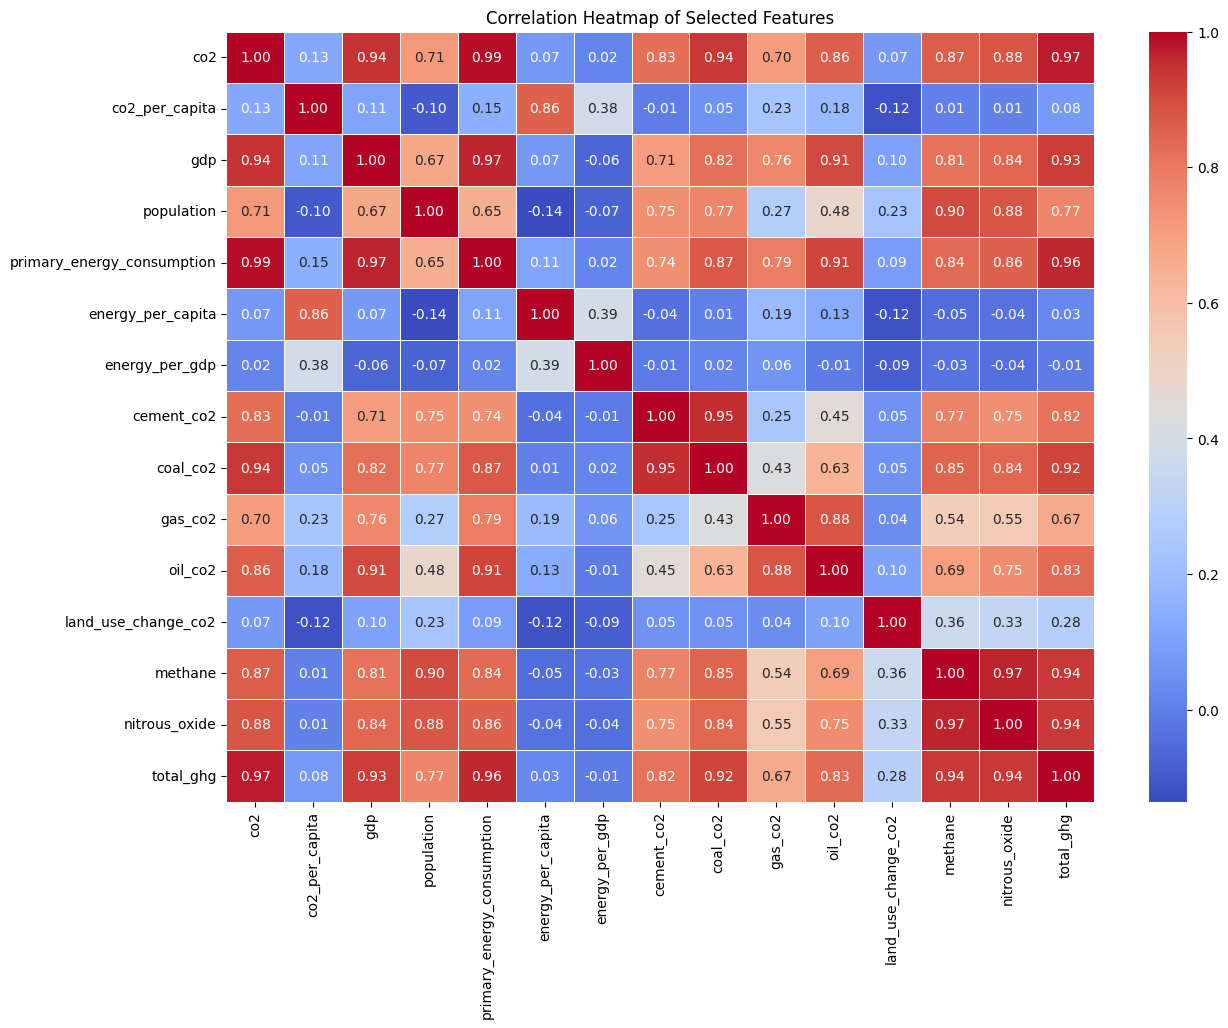

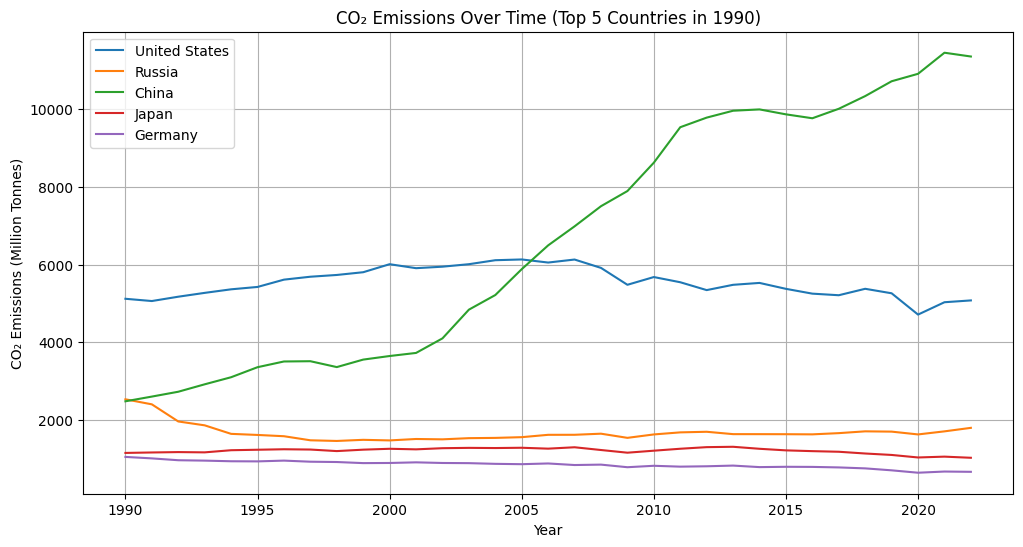

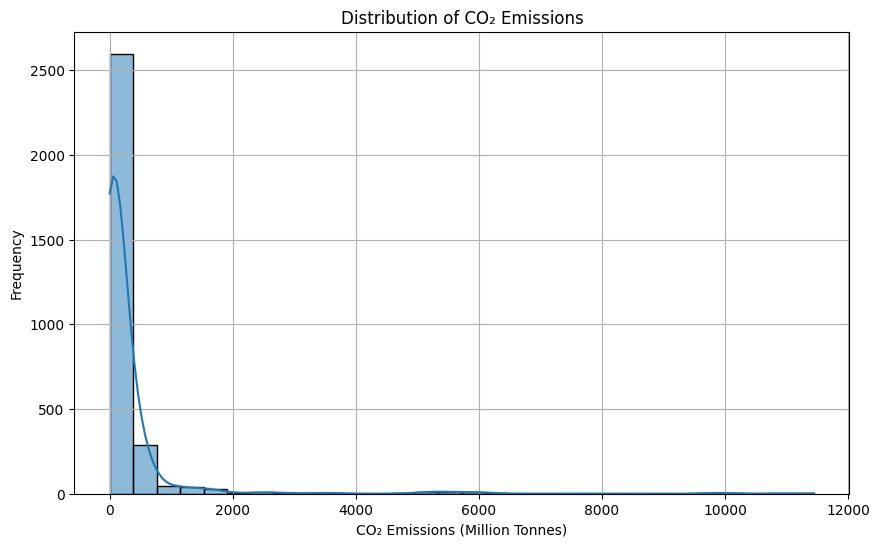

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = clean_df.drop(columns=['country', 'year']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

# 2. Time series line plot of CO2 emissions by country (example for top 5 emitting countries in 1990)
top_countries = clean_df[clean_df["year"] == 1990].sort_values(by="co2", ascending=False).head(5)["country"]
plt.figure(figsize=(12, 6))
for country in top_countries:
    subset = clean_df[clean_df["country"] == country]
    plt.plot(subset["year"], subset["co2"], label=country)
plt.title("CO₂ Emissions Over Time (Top 5 Countries in 1990)")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (Million Tonnes)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Distribution of CO2 emissions
plt.figure(figsize=(10, 6))
sns.histplot(clean_df["co2"], bins=30, kde=True)
plt.title("Distribution of CO₂ Emissions")
plt.xlabel("CO₂ Emissions (Million Tonnes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Scaling numerical features (for ML input)
numerical_features = clean_df.drop(columns=["country", "year"]).columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clean_df[numerical_features])
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features)
scaled_df["country"] = clean_df["country"].values
scaled_df["year"] = clean_df["year"].values




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare features and target
X = scaled_df.drop(columns=['co2', 'country', 'year'])
y = scaled_df['co2']

# 2. Train/test split based on year
train_idx = scaled_df['year'] < 2015
test_idx = scaled_df['year'] >= 2015

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# 3. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.3f}")
print(f"Linear Regression MAPE: {mape_lr:.3f}")

# 4. XGBoost Regression
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"\nXGBoost RMSE: {rmse_xgb:.3f}")
print(f"XGBoost MAPE: {mape_xgb:.3f}")



Linear Regression RMSE: 0.006
Linear Regression MAPE: 0.052

XGBoost RMSE: 0.141
XGBoost MAPE: 0.226


In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 300, 500]
}

# New XGBRegressor instance
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV to find best parameters
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',  # RMSE
                           cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

print("Best hyperparameters:", grid_search.best_params_)

# Predict using the best model
y_pred_best = best_xgb.predict(X_test)

# Evaluate
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)

print(f"Tuned XGBoost RMSE: {rmse_best:.3f}")
print(f"Tuned XGBoost MAPE: {mape_best:.3f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500}
Tuned XGBoost RMSE: 0.166
Tuned XGBoost MAPE: 0.144


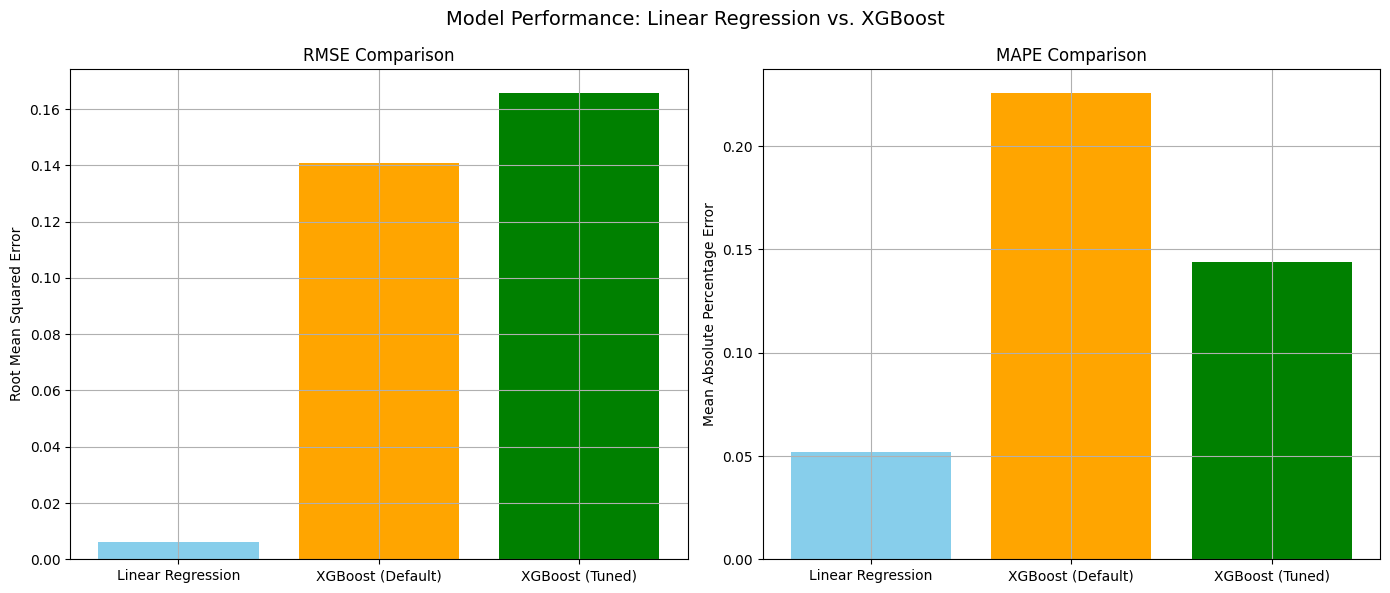

In [ ]:
import matplotlib.pyplot as plt

# Model names and metrics
models = ['Linear Regression', 'XGBoost (Default)', 'XGBoost (Tuned)']
rmse_scores = [rmse_lr, rmse_xgb,rmse_best]
mape_scores = [mape_lr, mape_xgb,mape_best]

# Create bar plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Plot
ax[0].bar(models, rmse_scores, color=['skyblue', 'orange', 'green'])
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('Root Mean Squared Error')
ax[0].grid(True)

# MAPE Plot
ax[1].bar(models, mape_scores, color=['skyblue', 'orange', 'green'])
ax[1].set_title('MAPE Comparison')
ax[1].set_ylabel('Mean Absolute Percentage Error')
ax[1].grid(True)

plt.suptitle('Model Performance: Linear Regression vs. XGBoost', fontsize=14)
plt.tight_layout()
plt.show()





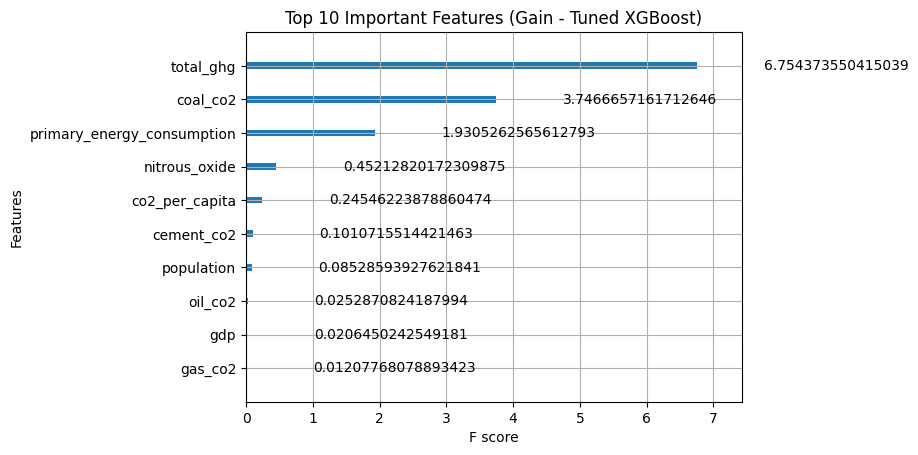

In [ ]:
# 6. XGBoost Feature Importance Plot

xgb.plot_importance(best_xgb, importance_type='gain', max_num_features=10)
plt.title('Top 10 Important Features (Gain - Tuned XGBoost)')
plt.show()


Feature importance based on standardized linear coefficients:
coal_co2                      0.636731
oil_co2                       0.286885
gas_co2                       0.176875
cement_co2                    0.063726
total_ghg                     0.037524
methane                       0.023387
population                    0.009246
land_use_change_co2           0.005062
primary_energy_consumption    0.003939
nitrous_oxide                 0.000299
gdp                           0.000262
energy_per_capita             0.000162
co2_per_capita                0.000153
energy_per_gdp                0.000052
dtype: float64


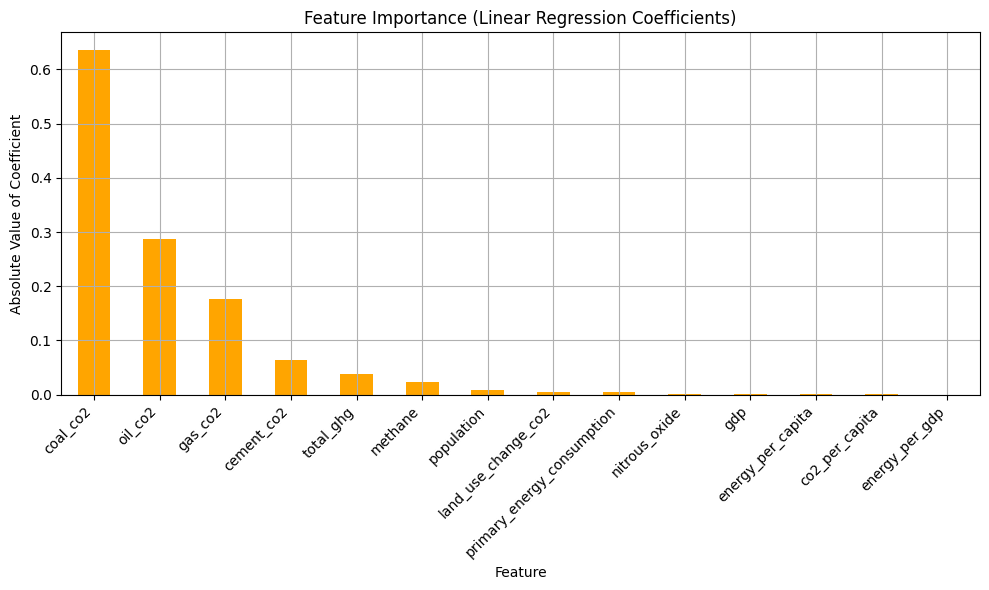

In [ ]:
#Feature Importance from Coefficients (Linear Regression)

feature_names = X.columns

#Absolute Coefficent Values
coef_importance = pd.Series(np.abs(lr_model.coef_), index=feature_names)
coef_importance_sorted = coef_importance.sort_values(ascending=False)

print("Feature importance based on standardized linear coefficients:")
print(coef_importance_sorted)

# Plot
plt.figure(figsize=(10, 6))
coef_importance_sorted.plot(kind='bar', color='orange')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.ylabel("Absolute Value of Coefficient")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
#Visualizing Tuned XGBoost

fig, ax = plt.subplots(figsize=(80, 40))

xgb.plot_tree(best_xgb, num_trees=0, rankdir='LR', ax=ax)


plt.savefig("tuned_xgb_tree.pdf", bbox_inches='tight')
plt.close()


### Model Comparison Summary:
- Linear Regression performed best (lowest RMSE and MAPE).
- XGBoost improved significantly after tuning, but still didn’t outperform Linear Regression.


# **SHAP Explainability and Interpretability for Linear Regression and XGBoost models**

In [ ]:
!pip install shap

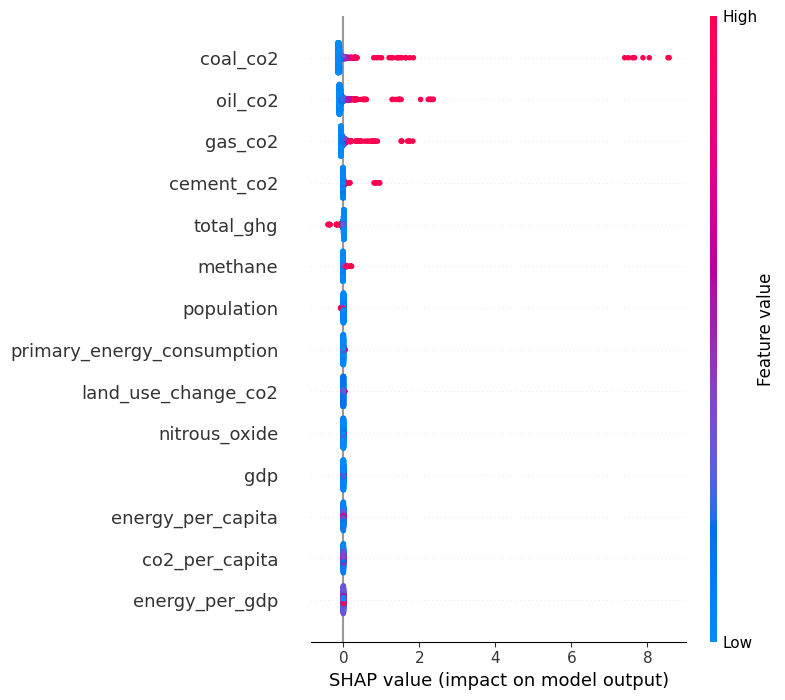

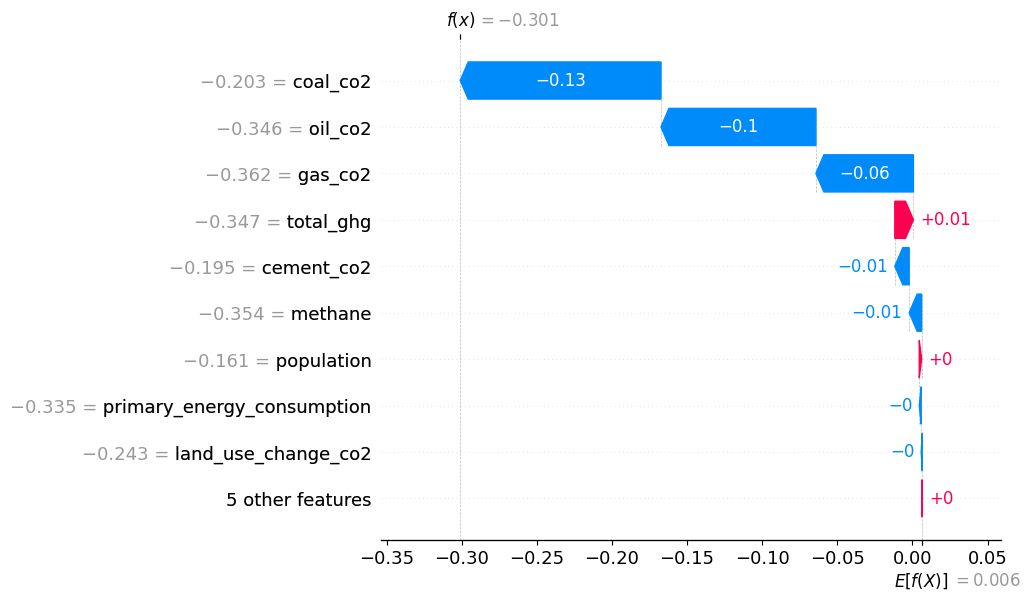

In [ ]:
import shap

# SHAP Summary Plot for Linear Regression Model
explainer_lr = shap.Explainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
shap.summary_plot(shap_values_lr, X_test)

# Example Waterfall Plot for Linear Regression Model
shap.waterfall_plot(shap_values_lr[0])

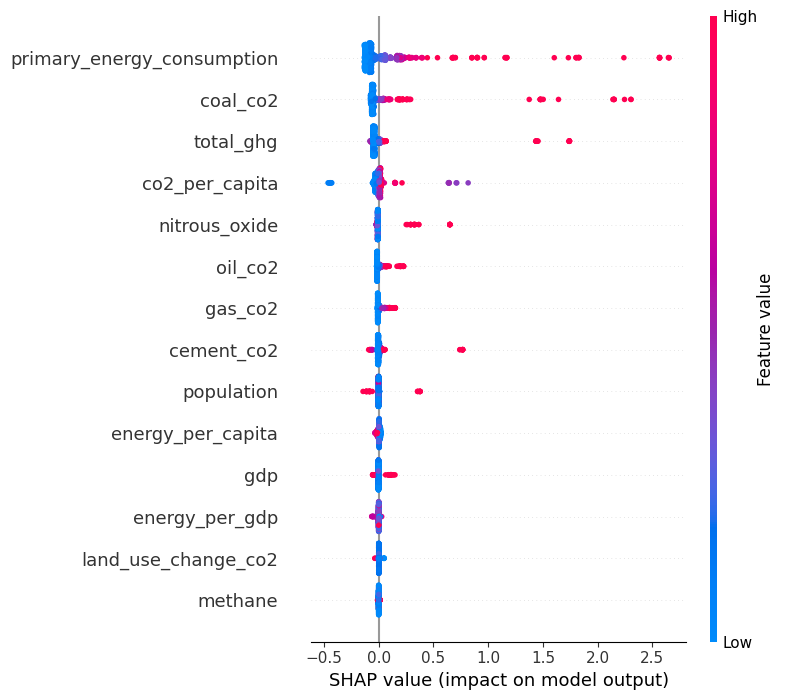

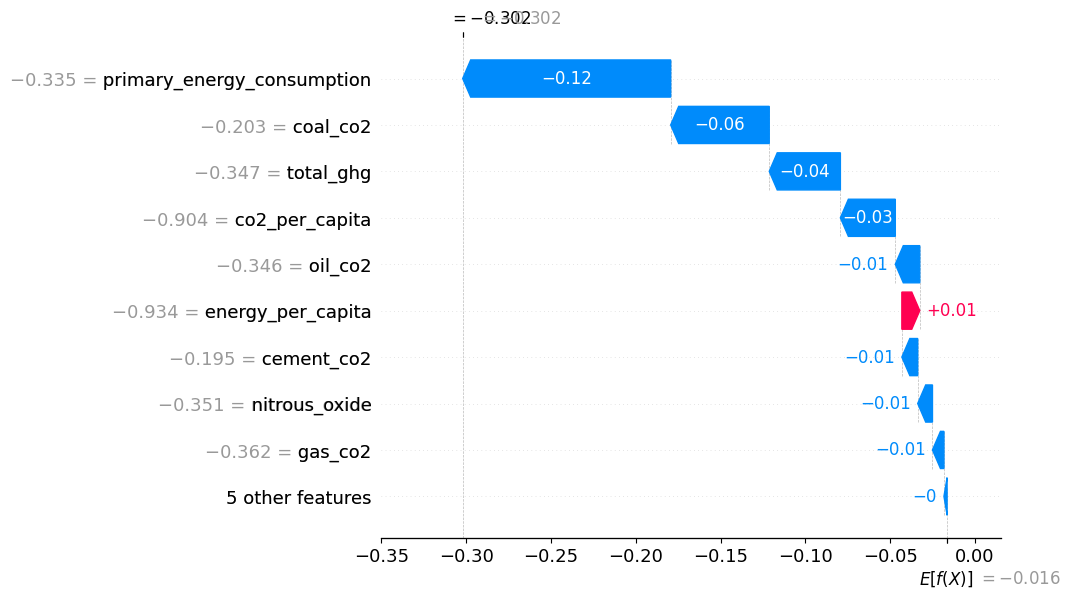

In [ ]:
# SHAP Summary Plot for Linear Regression Model
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, X_test)

# Example Waterfall Plot for XGBoost Model
shap.waterfall_plot(shap_values_xgb[0])

**Types of Potential Models Quick Overview**

**AR** - Autoregresive only considers short-term / recent past values, intended for stationary data (consistent mean and variance over time)

**ARMA** - AR Moving Average considers long term values, but still intended for stationary data (consistent mean and variance over time)

**ARIMA** - ARMA with differencing, considers long term values for non stationary data (that becomes stationary after differencing)
        Good for data that changes over time with upward/downward trends (like economic and financial data) and is also the most standardly used AR

**ARIMAX** - ARIMA with exogenous variables (features besides the target)

**SARIMA** - Seasonal ARIMA is ARIMA but accounts for seasonal trends

**VARIMA** - Vector ARIMA is used for multiple interrelated time series (modeling multiple time series relationships together) and supports vector notation

**RNN/LSTM/GRU** - Deep network time series, requires a ton of data, useful for nonlinear dependencies or long-term dependencies

**Transformers** - Adding attention to deep network, requires huge amount of features and data
<br>
<br>

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.02665625949310214
R-squared: 0.9835768325447598
MAPE: 0.004655174161884623


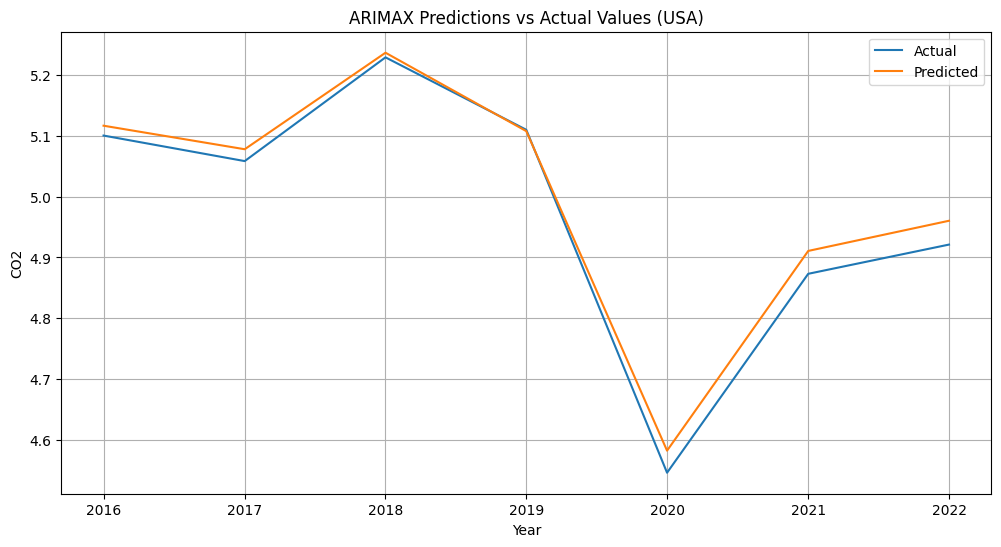

In [ ]:
# Run ARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Perform for a select country: USA, and prepare data as input
country = "United States"
country_df = scaled_df[scaled_df["country"] == country]
country_df = country_df.drop(columns=["country"])
country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
country_df = country_df.set_index('year')
country_df.index.freq = 'YS'

# Train test validation split
split = int(len(country_df) * 0.8)
split2 = int(len(country_df) * 1) # For now its a 80/20 split, can turn to 80/10/10 if attempting to optimize hyperparameters, but too low data for that right now

train_df = country_df[:split]
val_df = country_df[split:split2]
test_df = country_df[split2:]

exog_train = train_df.drop(columns=['co2'])
exog_val = val_df.drop(columns=['co2'])
exog_test = test_df.drop(columns=['co2'])

# Order consists of (p, d, q) where p is number of previous observations used, d is the amount of times
#   the data is differenced (to make data stable/remove trends), q is number of previous errors to consider
arimax_model = ARIMA(train_df['co2'], exog=exog_train, order=(3, 1, 3))
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(steps=(split2-split), exog=exog_val)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(val_df["co2"], arimax_predictions))
r2 = r2_score(val_df["co2"], arimax_predictions)
mape = mean_absolute_percentage_error(val_df["co2"], arimax_predictions)

print("RMSE:", rmse)
print("R-squared:", r2)
print("MAPE:", mape)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(val_df["co2"], label="Actual")
plt.plot(arimax_predictions, label="Predicted")
plt.title("ARIMAX Predictions vs Actual Values (USA)")
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
plt.grid(True)
plt.show()

Below I run the ARIMAX on China instead of the USA.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.04172073813858204
R-squared: 0.995405423806983
MAPE: 0.002994326391448755


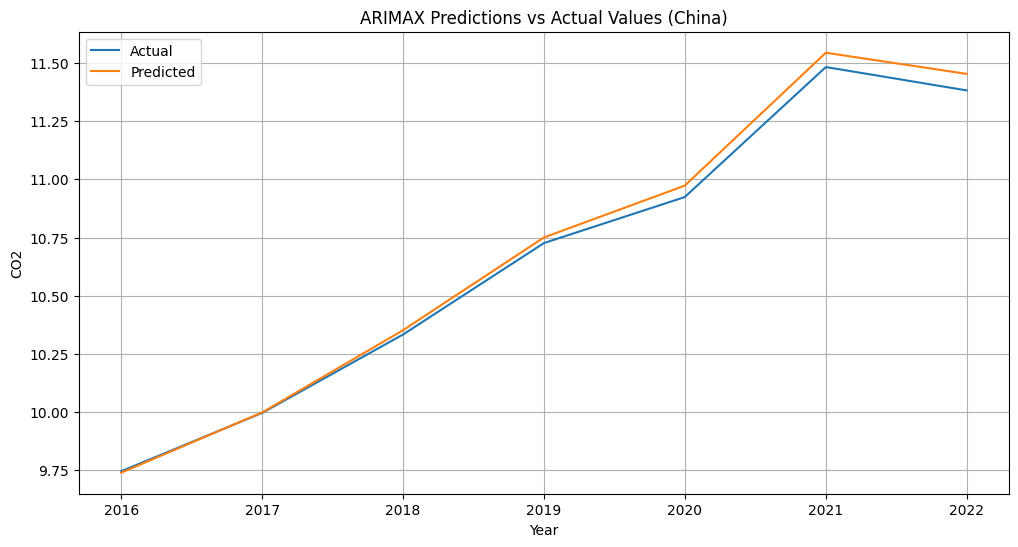

In [ ]:
# Run ARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Perform for a select country: China, and prepare data as input
country = "China"
country_df = scaled_df[scaled_df["country"] == country]
country_df = country_df.drop(columns=["country"])
country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
country_df = country_df.set_index('year')
country_df.index.freq = 'YS'

# Train test validation split
split = int(len(country_df) * 0.8)
split2 = int(len(country_df) * 1) # For now its a 80/20 split, can turn to 80/10/10 if attempting to optimize hyperparameters, but too low data for that right now

train_df = country_df[:split]
val_df = country_df[split:split2]
test_df = country_df[split2:]

exog_train = train_df.drop(columns=['co2'])
exog_val = val_df.drop(columns=['co2'])
exog_test = test_df.drop(columns=['co2'])

# Order consists of (p, d, q) where p is number of previous observations used, d is the amount of times
#   the data is differenced (to make data stable/remove trends), q is number of previous errors to consider
arimax_model = ARIMA(train_df['co2'], exog=exog_train, order=(3, 1, 3))
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(steps=(split2-split), exog=exog_val)

# Metrics
rmse = np.sqrt(mean_squared_error(val_df["co2"], arimax_predictions))
r2 = r2_score(val_df["co2"], arimax_predictions)
mape = mean_absolute_percentage_error(val_df["co2"], arimax_predictions)
print("RMSE:", rmse)
print("R-squared:", r2)
print("MAPE:", mape)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(val_df["co2"], label="Actual")
plt.plot(arimax_predictions, label="Predicted")
plt.title("ARIMAX Predictions vs Actual Values (China)")
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
plt.grid(True)
plt.show()

Below I ran ARIMA to compare the difference between having exogenous features and just being provided greenhouse gas emissions.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.3770620015582067
R-squared: -2.2861247258884996
MAPE: 0.06265035776779918


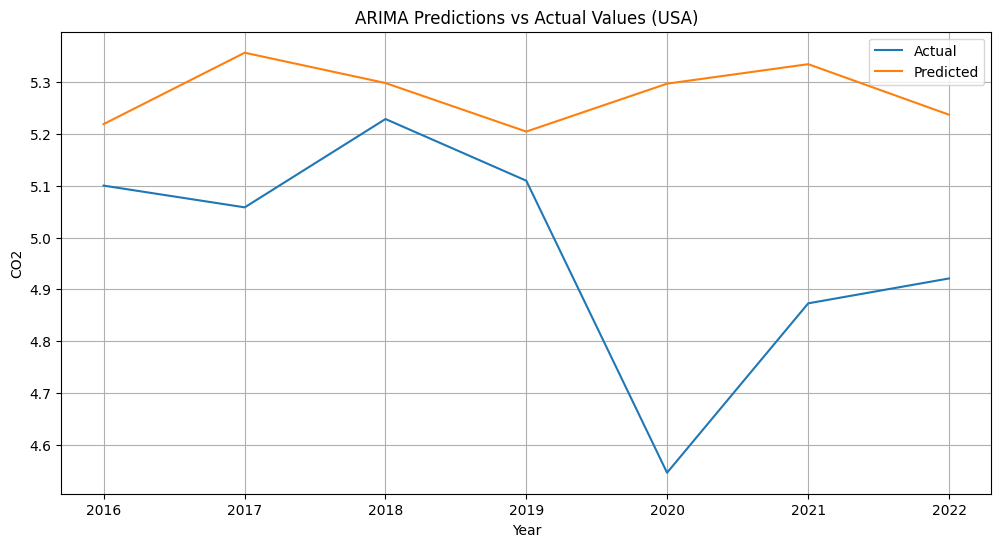

In [ ]:
# Run ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Perform for a select country: USA, and prepare data as input
country = "United States"
country_df = scaled_df[scaled_df["country"] == country]
country_df = country_df.drop(columns=["country"])
country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
country_df = country_df.set_index('year')
country_df.index.freq = 'YS'

# Train test validation split
split = int(len(country_df) * 0.8)
split2 = int(len(country_df) * 1) # For now its a 80/20 split, can turn to 80/10/10 if attempting to optimize hyperparameters, but too low data for that right now


train_df = country_df[:split]
val_df = country_df[split:split2]
test_df = country_df[split2:]

# Order consists of (p, d, q) where p is number of previous observations used, d is the amount of times
#   the data is differenced (to make data stable/remove trends), q is number of previous errors to consider
arima_model = ARIMA(train_df['co2'], order=(3, 1, 3))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=(split2-split))

# Metrics
rmse = np.sqrt(mean_squared_error(val_df["co2"], arima_predictions))
r2 = r2_score(val_df["co2"], arima_predictions)
mape = mean_absolute_percentage_error(val_df["co2"], arima_predictions)

print("RMSE:", rmse)
print("R-squared:", r2)
print("MAPE:", mape)

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(val_df["co2"], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title("ARIMA Predictions vs Actual Values (USA)")
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
plt.grid(True)
plt.show()

Summary Statistics for ARIMAX

In [ ]:
# ARIMAX Function - Performs ARIMAX and returns some summary statistics

def run_arimax(country):
  # Perform for a select country: USA, and prepare data as input
  country_df = scaled_df[scaled_df["country"] == country]
  country_df = country_df.drop(columns=["country"])
  country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
  country_df = country_df.set_index('year')
  country_df.index.freq = 'YS'

  # Train test validation split
  split = int(len(country_df) * 0.8)
  split2 = int(len(country_df) * 1) # For now its a 80/20 split, low amount of data so its difficult to optimize hyperparams (optimization per country)

  train_df = country_df[:split]
  val_df = country_df[split:split2]
  test_df = country_df[split2:] # Not used for now

  exog_train = train_df.drop(columns=['co2'])
  exog_val = val_df.drop(columns=['co2'])
  exog_test = test_df.drop(columns=['co2'])

  # Order consists of (p, d, q) where p is number of previous observations used, d is the amount of times
  #   the data is differenced (to make data stable/remove trends), q is number of previous errors to consider
  arimax_model = ARIMA(train_df['co2'], exog=exog_train, order=(3, 1, 3))
  arimax_model_fit = arimax_model.fit()
  arimax_predictions = arimax_model_fit.forecast(steps=(split2-split), exog=exog_val)

  # Metrics
  rmse = np.sqrt(mean_squared_error(val_df["co2"], arimax_predictions))
  r2 = r2_score(val_df["co2"], arimax_predictions)
  mape = mean_absolute_percentage_error(val_df["co2"], arimax_predictions)
  coefficients = arimax_model_fit.params


  # Return RMSE, R2, MAPE, coefficients
  return (rmse, r2, mape, coefficients)

In [ ]:
# Run for all countries
all_countries = scaled_df['country'].unique()
country_list = []
rmse_list = []
r2_list = []
mape_list = []
coefficients_list = []

# Double loop, performs many iterations
for i in (all_countries):
  # Code won't work if time-gap
  try:
    rmse, r2, mape, coefficients = run_arimax(i)
    country_list.append(i)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mape_list.append(mape)
    coefficients_list.append(coefficients)
  except:
    continue # Skips to next iteration

# Combine into a dataframe
summary_df = pd.DataFrame({
    'Country': country_list,
    'RMSE': rmse_list,
    'MAPE': mape_list,
     'R2': r2_list
})

summary_coefficients = pd.DataFrame(coefficients_list)

# Warnings - failed to converge (too low data)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:60

In [ ]:
summary_df

,Country,RMSE,MAPE,R2
0,Afghanistan,0.000005,0.000013,0.999969
1,Albania,0.000029,0.000073,0.984836
2,Algeria,0.000271,0.001490,0.999065
3,Argentina,0.001554,0.009552,0.982025
4,Armenia,0.000002,0.000008,0.999990
...,...,...,...,...
96,Uruguay,0.000002,0.000004,0.999994
97,Uzbekistan,0.000988,0.004761,0.982281
98,Venezuela,0.005118,0.019083,0.965502
99,Vietnam,0.002155,0.042164,0.998310


In [ ]:
summary_coefficients

,co2_per_capita,gdp,population,primary_energy_consumption,energy_per_capita,energy_per_gdp,cement_co2,coal_co2,gas_co2,oil_co2,...,methane,nitrous_oxide,total_ghg,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.L3,sigma2
0,0.001096,-0.000785,0.000235,-0.000495,-0.000042,0.000003,0.063405,0.615872,0.164536,0.282700,...,0.000164,0.000795,-0.006068,-2.143431e-01,-4.010112e-01,-1.055480e-01,-1.603567e-11,7.338488e-12,-2.582307e-12,7.254662e-12
1,0.001268,0.001982,0.013107,0.008500,-0.000296,0.000006,0.053915,0.588044,0.150179,0.266771,...,-0.000262,0.000114,0.003101,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-10
2,0.050124,0.008025,0.067483,0.099937,-0.019992,-0.000722,-0.003969,-0.016602,0.000776,0.003866,...,-0.152123,-0.053472,0.968671,-2.209430e-01,-5.146449e-01,-6.223529e-01,-3.273510e-01,5.734047e-01,3.198596e-01,1.380394e-08
3,0.255043,0.105073,0.308894,0.239974,-0.124487,0.013629,-0.054359,0.103131,0.011184,0.034266,...,0.025451,-0.014106,-0.003232,-7.059753e-01,-2.987875e-01,1.835964e-01,9.293613e-09,-1.608915e-08,-8.217777e-09,1.785517e-08
4,0.000328,-0.000737,0.001467,0.008239,-0.000215,-0.000009,0.057055,0.608689,0.165837,0.277943,...,0.000354,-0.000164,-0.000321,-3.071300e-02,-8.866516e-02,-8.738765e-02,-8.565649e-02,3.496718e-01,-3.683569e-01,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.001640,-0.001228,0.076967,-0.050624,0.001648,-0.000019,0.053199,0.738484,0.153385,0.263569,...,-0.000003,-0.000040,0.000562,-8.761548e-11,-1.617942e-13,1.220380e-13,-8.761461e-11,-1.626742e-13,1.202878e-13,1.660725e-11
97,0.012730,-0.107374,0.339623,-0.152961,0.049150,-0.002157,0.011865,0.061564,0.029166,0.033469,...,-0.140182,-0.047859,0.957577,-1.114645e+00,-5.656950e-01,2.478931e-01,2.613805e-05,-1.194624e-05,-3.637546e-05,1.961301e-08
98,0.088378,0.234028,0.338851,-0.075782,-0.030299,0.015934,0.023039,0.235828,0.049809,0.095656,...,-0.039691,-0.023468,0.254357,1.024788e-07,-2.441198e-07,-6.339620e-08,1.024705e-07,-2.441300e-07,-6.340466e-08,4.939243e-07
99,0.257521,-0.062499,0.020790,0.242064,-0.071351,-0.017693,0.032225,0.332884,0.078252,0.163502,...,-0.002941,0.000198,0.042615,-1.191226e+00,-1.634949e-01,1.793889e-01,2.545287e-07,-2.065880e-07,2.189915e-07,6.015007e-08


In [ ]:
#AutoRegressive Model Metrics
summary_df
summary_df.mean(numeric_only=True)

,0
RMSE,0.001567
MAPE,0.006677
R2,0.523646


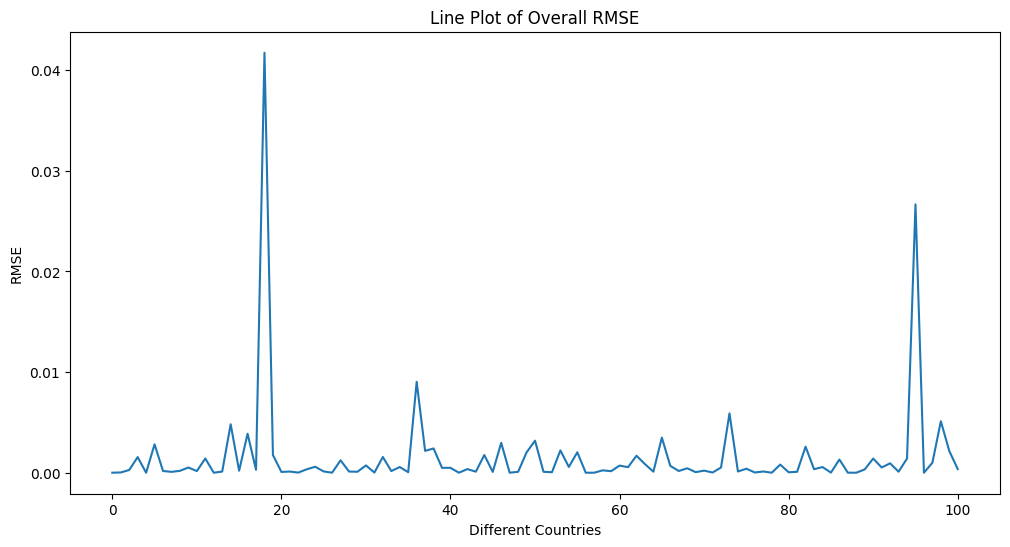

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(summary_df['RMSE'])
plt.xlabel('Different Countries')
plt.ylabel('RMSE')
plt.title('Line Plot of Overall RMSE')
plt.show()

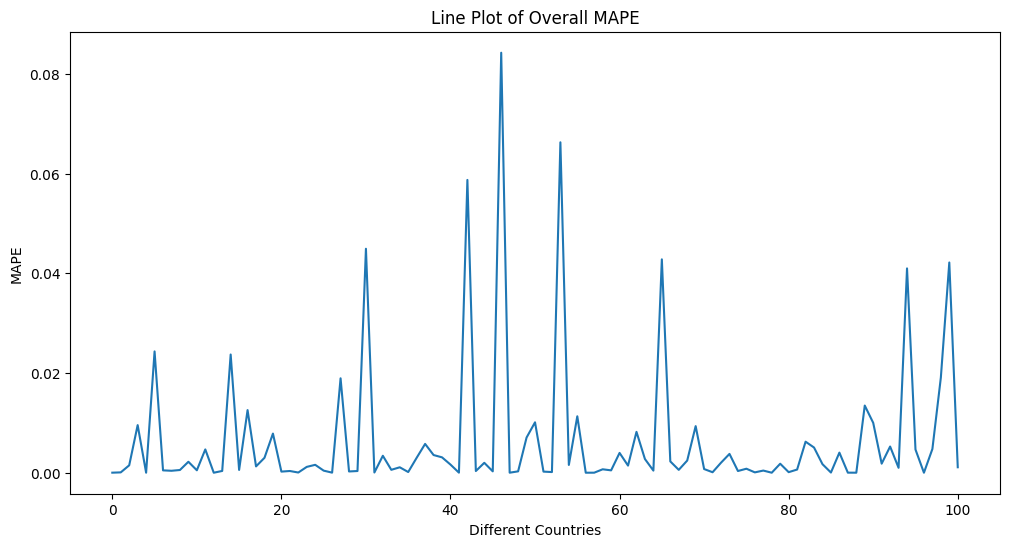

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(summary_df['MAPE'])
plt.xlabel('Different Countries')
plt.ylabel('MAPE')
plt.title('Line Plot of Overall MAPE')
plt.show()

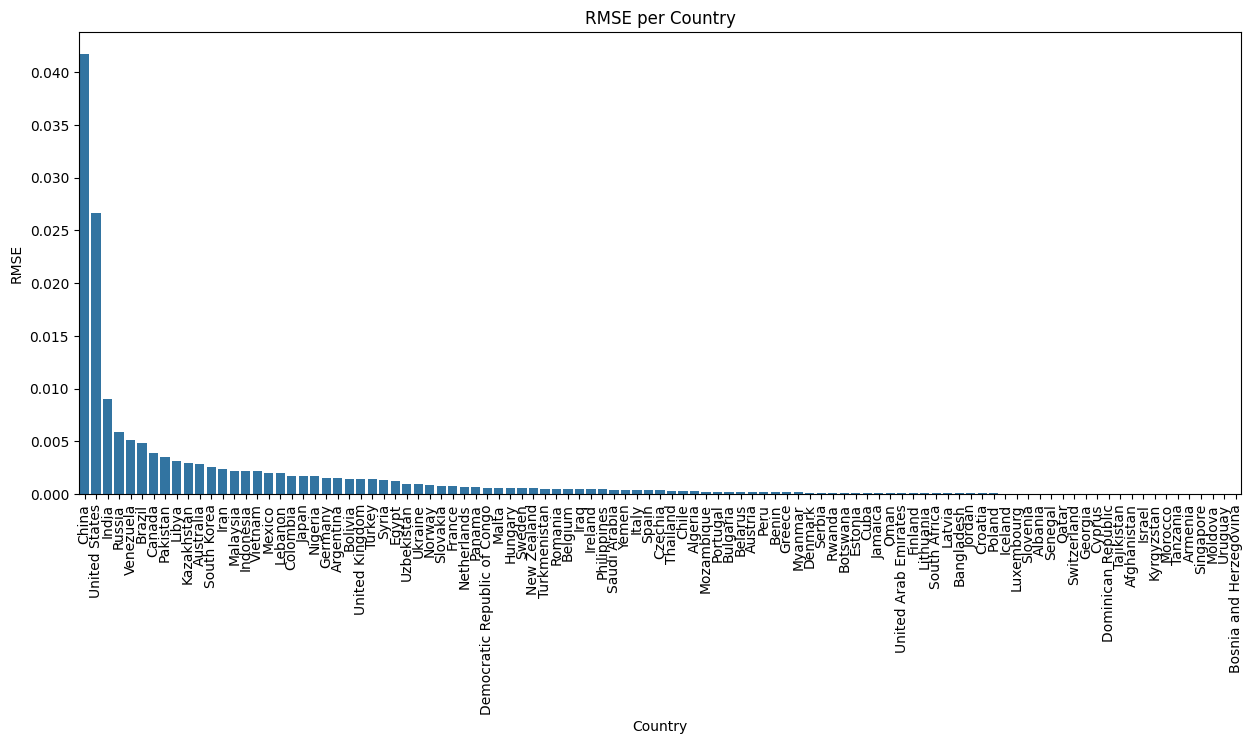

In [ ]:
# Sort countries by RMSE Score
sorted_df = summary_df.sort_values('RMSE', ascending=False)

plt.figure(figsize=(15,6))
sns.barplot(x='Country', y='RMSE', data=sorted_df)
plt.xticks(rotation=90)
plt.title('RMSE per Country')
plt.show()


In [ ]:
# Count number of countries with RMSE of .05 or less
count = (summary_df['RMSE'] <= 0.005).sum()
print(f"Number of countries with RMSE <= 0.05: {count}")

# Print average values
print("Average RMSE:", summary_df['RMSE'].mean())
print("Average MAPE:", summary_df['MAPE'].mean())

Number of countries with RMSE <= 0.05: 96
Average RMSE: 0.0015665067725602671
Average MAPE: 0.0066767195694540414


# **Coefficients for ARIMA and ARIMAX models**

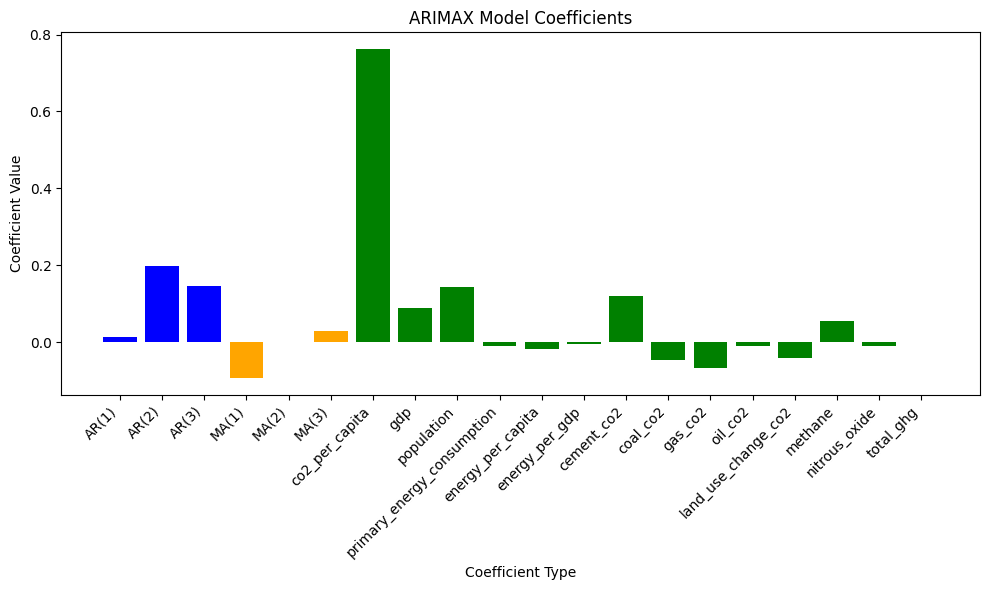

ARIMAX Model Coefficients:
co2_per_capita                1.285245e-01
gdp                           1.289151e-01
population                   -2.610762e-03
primary_energy_consumption    8.931275e-03
energy_per_capita            -1.385770e-01
energy_per_gdp                1.413888e-02
cement_co2                   -2.806023e-02
coal_co2                      7.450704e-03
gas_co2                       3.895258e-02
oil_co2                       1.486913e-01
land_use_change_co2          -4.287335e-02
methane                      -1.962764e-03
nitrous_oxide                 4.212291e-02
total_ghg                     6.890205e-02
ar.L1                         1.726505e-11
ar.L2                        -6.949153e-18
ar.L3                         1.624217e-16
ma.L1                         1.726518e-11
ma.L2                        -2.895301e-17
ma.L3                        -1.810312e-16
sigma2                        3.200809e-10
dtype: float64


In [ ]:
avg_coefficients = summary_coefficients.mean() # Averages the coefficients
ar_coeffs = avg_coefficients[1:4]  # AR terms (for AR(3), index may need to be adjusted based on order)
ma_coeffs = avg_coefficients[4:7]  # MA terms (for MA(3))
exog_coeffs = avg_coefficients[7:]  # Exogenous variables

# Combine coefficients for plotting
all_coeffs = list(ar_coeffs) + list(ma_coeffs) + list(exog_coeffs)
all_labels = [f'AR({i})' for i in range(1, 4)] + [f'MA({i})' for i in range(1, 4)] + list(exog_train.columns)

# Coefficients Plot
plt.figure(figsize=(10, 6))
plt.bar(all_labels, all_coeffs, color=['blue'] * 3 + ['orange'] * 3 + ['green'] * len(exog_train.columns))
plt.title('ARIMAX Model Coefficients')
plt.xlabel('Coefficient Type')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Coefficients Values Table
print("ARIMAX Model Coefficients:")
print(coefficients)

<ipython-input-25-eaef54dd6d9d>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coefficients[0]    # Intercept


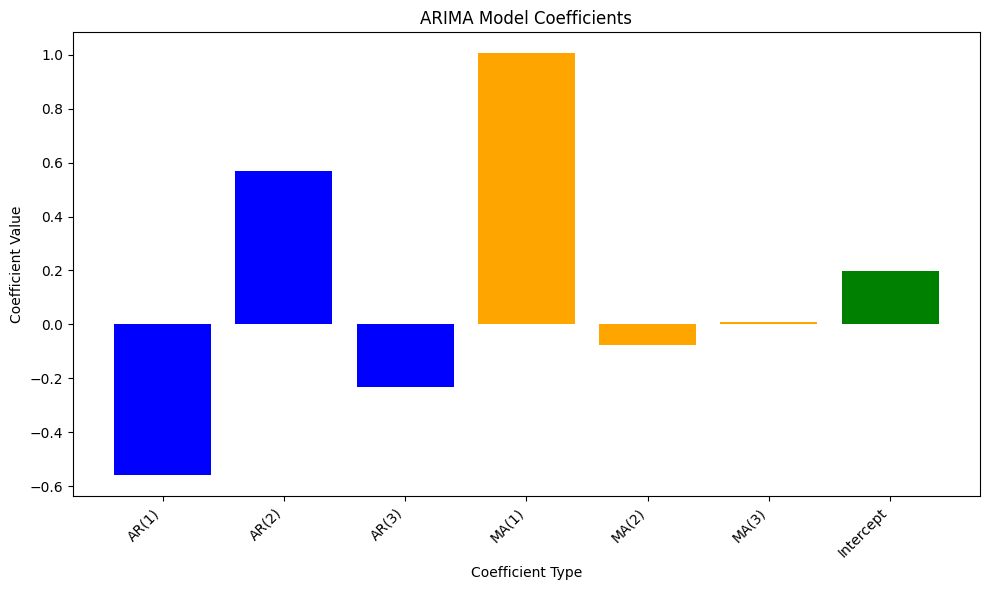

ARIMA Model Coefficients:
ar.L1     0.198594
ar.L2    -0.560360
ar.L3     0.567999
ma.L1    -0.231468
ma.L2     1.005228
ma.L3    -0.077105
sigma2    0.010000
dtype: float64


In [ ]:
coefficients = arima_model_fit.params

# Extract AR, MA, and intercept coefficients
ar_coeffs = coefficients[1:4]  # AR(1), AR(2), AR(3)
ma_coeffs = coefficients[4:7]  # MA(1), MA(2), MA(3)
intercept = coefficients[0]    # Intercept

# Combine coefficients for plotting
all_coeffs = list(ar_coeffs) + list(ma_coeffs) + [intercept]
all_labels = [f'AR({i})' for i in range(1, 4)] + [f'MA({i})' for i in range(1, 4)] + ['Intercept']

# Coefficients Plot
plt.figure(figsize=(10, 6))
plt.bar(all_labels, all_coeffs, color=['blue'] * 3 + ['orange'] * 3 + ['green'])
plt.title('ARIMA Model Coefficients')
plt.xlabel('Coefficient Type')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Coefficients Values Table
print("ARIMA Model Coefficients:")
print(coefficients)